In [1]:
! pip install optuna

  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.16.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.3.0-py3-none-any.whl (386 kB)
Using cached alembic-1.16.1-py3-none-any.whl (242 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

import optuna
from tqdm import tqdm

Random Seed:  999


In [4]:
# Root directory for dataset
dataroot = "data/mnist_data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST(
    root=dataroot,
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.18MB/s]


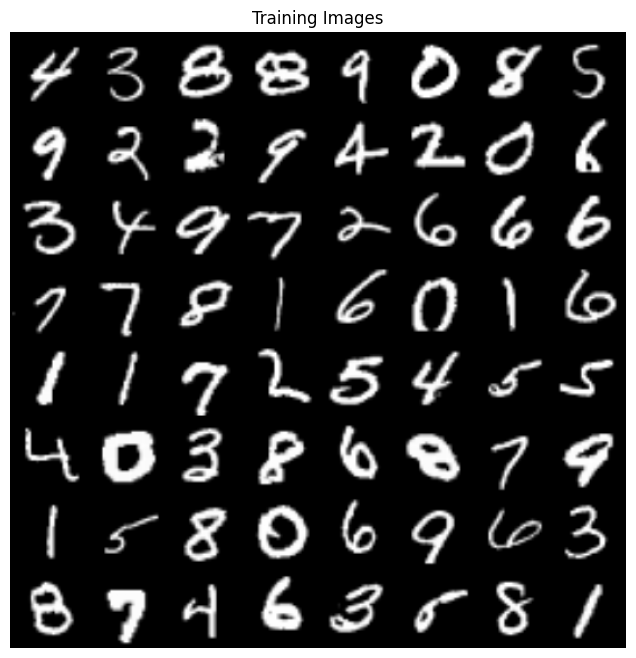

In [6]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the `weights_init`
function. Check out the printed model to see how the generator object is
structured.


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
def objective(trial):
    print(f"Starting trial {trial.number}...")

    # Define hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate
    nz = trial.suggest_int('nz', 50, 200)  # Latent vector size
    ngf = trial.suggest_categorical('ngf', [32, 64, 128])  # Generator feature maps
    ndf = trial.suggest_categorical('ndf', [32, 64, 128])  # Discriminator feature maps
    beta1 = trial.suggest_float('beta1', 0.3, 0.9)  # Tuning beta1

    # Initialize models
    # Create the generator
    netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    netG.apply(weights_init)

    # Create the Discriminator
    netD = Discriminator(ngpu=ngpu, ndf=ndf, nc=nc).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    # like this: ``to mean=0, stdev=0.2``.
    netD.apply(weights_init)


    # Set up Adam optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Binary Cross Entropy Loss
    criterion = nn.BCELoss()

    # Initialize fixed noise for evaluation
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    # Training loop
    for epoch in range(num_epochs):
        epoch_D_loss = 0
        epoch_G_loss = 0
        print(f"Epoch {epoch+1}/{num_epochs}...")

        for i, data in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch+1}"), 0):
            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), 1., dtype=torch.float, device=device)

            # Flatten the output of the discriminator
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.)
            # Flatten the output of the discriminator
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            label.fill_(1.)  # fake labels are real for generator cost
            # Flatten the output of the discriminator
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Save losses for later analysis
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            epoch_D_loss += errD.item()
            epoch_G_loss += errG.item()

            iters += 1

        # Log the average losses for the epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss D: {epoch_D_loss / len(dataloader):.4f} - Avg Loss G: {epoch_G_loss / len(dataloader):.4f}")

        # Save generated images
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Final loss for the objective function
    final_loss = sum(D_losses)/2 + sum(G_losses)/2
    print(f"Trial {trial.number} complete - Total Discriminator Loss: {final_loss:.4f}")
    return final_loss  # Minimize the discriminator loss

In [12]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Run 50 trials to explore different hyperparameters

# Print the best hyperparameters found
print("Best hyperparameters: ", study.best_params)

# After the study is complete, you can retrieve the best model settings
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

[I 2025-06-02 21:51:02,733] A new study created in memory with name: no-name-9b5fd7a1-bdf4-40a8-b63c-44ba479da81c
<ipython-input-11-367d7c055d17>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Starting trial 0...
Epoch 1/5...


Training Epoch 1:   0%|          | 2/469 [00:01<05:50,  1.33it/s]

Iteration 0: Loss_D: 1.3227	Loss_G: 7.6805


Training Epoch 1:  12%|█▏        | 54/469 [00:05<00:30, 13.67it/s]

Iteration 50: Loss_D: 0.4129	Loss_G: 3.9773


Training Epoch 1:  22%|██▏       | 104/469 [00:09<00:22, 15.99it/s]

Iteration 100: Loss_D: 2.2784	Loss_G: 5.8352


Training Epoch 1:  32%|███▏      | 152/469 [00:12<00:23, 13.31it/s]

Iteration 150: Loss_D: 0.9166	Loss_G: 2.3004


Training Epoch 1:  43%|████▎     | 204/469 [00:16<00:16, 15.85it/s]

Iteration 200: Loss_D: 0.7170	Loss_G: 1.6530


Training Epoch 1:  54%|█████▎    | 252/469 [00:19<00:14, 15.37it/s]

Iteration 250: Loss_D: 1.5561	Loss_G: 0.6444


Training Epoch 1:  65%|██████▍   | 304/469 [00:22<00:10, 15.71it/s]

Iteration 300: Loss_D: 0.6922	Loss_G: 1.5065


Training Epoch 1:  75%|███████▌  | 352/469 [00:25<00:09, 12.65it/s]

Iteration 350: Loss_D: 0.6451	Loss_G: 1.0518


Training Epoch 1:  86%|████████▌ | 404/469 [00:29<00:04, 15.73it/s]

Iteration 400: Loss_D: 0.8204	Loss_G: 1.8152


Training Epoch 1:  97%|█████████▋| 454/469 [00:32<00:00, 16.01it/s]

Iteration 450: Loss_D: 0.9723	Loss_G: 1.0132


Training Epoch 1: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]


Epoch 1/5 - Avg Loss D: 0.9650 - Avg Loss G: 2.8879
Epoch 2/5...


Training Epoch 2:   7%|▋         | 35/469 [00:02<00:28, 15.50it/s]

Iteration 500: Loss_D: 0.7696	Loss_G: 1.7979


Training Epoch 2:  18%|█▊        | 83/469 [00:05<00:31, 12.24it/s]

Iteration 550: Loss_D: 0.8447	Loss_G: 1.2430


Training Epoch 2:  29%|██▉       | 135/469 [00:09<00:21, 15.70it/s]

Iteration 600: Loss_D: 0.9298	Loss_G: 1.0684


Training Epoch 2:  39%|███▉      | 185/469 [00:12<00:18, 15.67it/s]

Iteration 650: Loss_D: 0.7688	Loss_G: 1.3119


Training Epoch 2:  50%|█████     | 235/469 [00:15<00:14, 15.72it/s]

Iteration 700: Loss_D: 0.8007	Loss_G: 1.1808


Training Epoch 2:  60%|██████    | 283/469 [00:19<00:15, 12.24it/s]

Iteration 750: Loss_D: 0.9893	Loss_G: 3.1583


Training Epoch 2:  71%|███████▏  | 335/469 [00:23<00:08, 15.60it/s]

Iteration 800: Loss_D: 0.9286	Loss_G: 2.2195


Training Epoch 2:  82%|████████▏ | 385/469 [00:26<00:05, 15.50it/s]

Iteration 850: Loss_D: 0.8201	Loss_G: 1.8562


Training Epoch 2:  93%|█████████▎| 435/469 [00:29<00:02, 15.51it/s]

Iteration 900: Loss_D: 0.6985	Loss_G: 1.6708


Training Epoch 2: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Epoch 2/5 - Avg Loss D: 1.0073 - Avg Loss G: 1.7253
Epoch 3/5...


Training Epoch 3:   3%|▎         | 16/469 [00:01<00:31, 14.24it/s]

Iteration 950: Loss_D: 0.7033	Loss_G: 1.5216


Training Epoch 3:  14%|█▍        | 66/469 [00:04<00:26, 15.38it/s]

Iteration 1000: Loss_D: 1.4687	Loss_G: 3.0882


Training Epoch 3:  24%|██▍       | 114/469 [00:07<00:23, 15.32it/s]

Iteration 1050: Loss_D: 0.8480	Loss_G: 2.3652


Training Epoch 3:  35%|███▍      | 164/469 [00:11<00:24, 12.59it/s]

Iteration 1100: Loss_D: 1.2248	Loss_G: 4.3047


Training Epoch 3:  46%|████▌     | 216/469 [00:15<00:16, 15.19it/s]

Iteration 1150: Loss_D: 1.2693	Loss_G: 3.0405


Training Epoch 3:  57%|█████▋    | 266/469 [00:18<00:13, 15.19it/s]

Iteration 1200: Loss_D: 0.5898	Loss_G: 5.0899


Training Epoch 3:  67%|██████▋   | 316/469 [00:21<00:10, 15.15it/s]

Iteration 1250: Loss_D: 0.4520	Loss_G: 2.0975


Training Epoch 3:  78%|███████▊  | 364/469 [00:25<00:09, 11.34it/s]

Iteration 1300: Loss_D: 0.6905	Loss_G: 3.4727


Training Epoch 3:  88%|████████▊ | 414/469 [00:29<00:04, 11.77it/s]

Iteration 1350: Loss_D: 1.0039	Loss_G: 1.0879


Training Epoch 3:  99%|█████████▉| 466/469 [00:33<00:00, 15.18it/s]

Iteration 1400: Loss_D: 0.7197	Loss_G: 4.7659


Training Epoch 3: 100%|██████████| 469/469 [00:33<00:00, 14.08it/s]


Epoch 3/5 - Avg Loss D: 0.9120 - Avg Loss G: 2.3364
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:03<00:29, 14.17it/s]

Iteration 1450: Loss_D: 1.0463	Loss_G: 4.3069


Training Epoch 4:  21%|██        | 97/469 [00:07<00:24, 15.12it/s]

Iteration 1500: Loss_D: 0.7243	Loss_G: 4.2819


Training Epoch 4:  31%|███▏      | 147/469 [00:10<00:21, 15.26it/s]

Iteration 1550: Loss_D: 0.7075	Loss_G: 4.0006


Training Epoch 4:  42%|████▏     | 197/469 [00:13<00:17, 15.18it/s]

Iteration 1600: Loss_D: 0.4872	Loss_G: 1.9908


Training Epoch 4:  52%|█████▏    | 245/469 [00:17<00:18, 12.37it/s]

Iteration 1650: Loss_D: 0.9333	Loss_G: 1.5697


Training Epoch 4:  63%|██████▎   | 297/469 [00:21<00:11, 15.32it/s]

Iteration 1700: Loss_D: 0.3290	Loss_G: 2.3571


Training Epoch 4:  74%|███████▍  | 347/469 [00:24<00:07, 15.34it/s]

Iteration 1750: Loss_D: 0.5803	Loss_G: 4.9586


Training Epoch 4:  85%|████████▍ | 397/469 [00:27<00:04, 15.15it/s]

Iteration 1800: Loss_D: 1.0055	Loss_G: 0.8564


Training Epoch 4:  95%|█████████▍| 445/469 [00:31<00:02, 11.98it/s]

Iteration 1850: Loss_D: 1.2899	Loss_G: 0.8308


Training Epoch 4: 100%|██████████| 469/469 [00:33<00:00, 14.15it/s]


Epoch 4/5 - Avg Loss D: 0.7695 - Avg Loss G: 2.7570
Epoch 5/5...


Training Epoch 5:   6%|▌         | 27/469 [00:01<00:29, 15.15it/s]

Iteration 1900: Loss_D: 0.6647	Loss_G: 3.9031


Training Epoch 5:  16%|█▋        | 77/469 [00:05<00:25, 15.10it/s]

Iteration 1950: Loss_D: 0.8772	Loss_G: 2.7297


Training Epoch 5:  27%|██▋       | 127/469 [00:08<00:22, 15.09it/s]

Iteration 2000: Loss_D: 0.9136	Loss_G: 6.8628


Training Epoch 5:  38%|███▊      | 177/469 [00:12<00:19, 14.86it/s]

Iteration 2050: Loss_D: 0.1479	Loss_G: 4.7198


Training Epoch 5:  48%|████▊     | 227/469 [00:15<00:15, 15.17it/s]

Iteration 2100: Loss_D: 1.2070	Loss_G: 0.8561


Training Epoch 5:  59%|█████▉    | 277/469 [00:18<00:12, 15.01it/s]

Iteration 2150: Loss_D: 1.0515	Loss_G: 1.3922


Training Epoch 5:  70%|██████▉   | 327/469 [00:22<00:11, 12.15it/s]

Iteration 2200: Loss_D: 1.2856	Loss_G: 4.0912


Training Epoch 5:  80%|████████  | 377/469 [00:26<00:06, 15.25it/s]

Iteration 2250: Loss_D: 0.8776	Loss_G: 3.0727


Training Epoch 5:  91%|█████████ | 427/469 [00:29<00:02, 15.11it/s]

Iteration 2300: Loss_D: 0.6486	Loss_G: 2.5458


Training Epoch 5: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]
[I 2025-06-02 21:53:47,547] Trial 0 finished with value: 4000.772911692038 and parameters: {'lr': 0.000776403715383726, 'nz': 141, 'ngf': 32, 'ndf': 32, 'beta1': 0.42745042760281404}. Best is trial 0 with value: 4000.772911692038.


Epoch 5/5 - Avg Loss D: 0.6716 - Avg Loss G: 3.0290
Trial 0 complete - Total Discriminator Loss: 4000.7729
Starting trial 1...
Epoch 1/5...


Training Epoch 1:   0%|          | 2/469 [00:00<01:17,  6.06it/s]

Iteration 0: Loss_D: 1.3080	Loss_G: 1.0544


Training Epoch 1:  11%|█▏        | 53/469 [00:05<00:41, 10.12it/s]

Iteration 50: Loss_D: 0.3157	Loss_G: 3.0527


Training Epoch 1:  22%|██▏       | 102/469 [00:10<00:35, 10.37it/s]

Iteration 100: Loss_D: 0.1929	Loss_G: 3.8170


Training Epoch 1:  32%|███▏      | 152/469 [00:15<00:31, 10.19it/s]

Iteration 150: Loss_D: 0.0733	Loss_G: 4.2764


Training Epoch 1:  43%|████▎     | 202/469 [00:20<00:25, 10.49it/s]

Iteration 200: Loss_D: 0.0548	Loss_G: 4.5439


Training Epoch 1:  54%|█████▎    | 252/469 [00:25<00:20, 10.36it/s]

Iteration 250: Loss_D: 0.0329	Loss_G: 4.7526


Training Epoch 1:  64%|██████▍   | 302/469 [00:30<00:17,  9.30it/s]

Iteration 300: Loss_D: 0.0200	Loss_G: 5.0191


Training Epoch 1:  75%|███████▌  | 352/469 [00:35<00:11, 10.40it/s]

Iteration 350: Loss_D: 0.0152	Loss_G: 5.1772


Training Epoch 1:  86%|████████▌ | 402/469 [00:39<00:06, 10.33it/s]

Iteration 400: Loss_D: 0.0164	Loss_G: 5.3005


Training Epoch 1:  97%|█████████▋| 453/469 [00:45<00:01, 10.29it/s]

Iteration 450: Loss_D: 0.0108	Loss_G: 5.4198


Training Epoch 1: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]


Epoch 1/5 - Avg Loss D: 0.1236 - Avg Loss G: 4.4350
Epoch 2/5...


Training Epoch 2:   7%|▋         | 33/469 [00:03<00:41, 10.40it/s]

Iteration 500: Loss_D: 0.0083	Loss_G: 5.6379


Training Epoch 2:  18%|█▊        | 83/469 [00:08<00:52,  7.40it/s]

Iteration 550: Loss_D: 0.0079	Loss_G: 5.7727


Training Epoch 2:  28%|██▊       | 133/469 [00:14<00:32, 10.40it/s]

Iteration 600: Loss_D: 0.0048	Loss_G: 6.0060


Training Epoch 2:  39%|███▉      | 183/469 [00:18<00:27, 10.35it/s]

Iteration 650: Loss_D: 0.0060	Loss_G: 5.7774


Training Epoch 2:  50%|████▉     | 234/469 [00:24<00:22, 10.31it/s]

Iteration 700: Loss_D: 0.0066	Loss_G: 5.7950


Training Epoch 2:  61%|██████    | 284/469 [00:28<00:17, 10.41it/s]

Iteration 750: Loss_D: 0.0059	Loss_G: 5.9869


Training Epoch 2:  71%|███████   | 333/469 [00:33<00:15,  8.82it/s]

Iteration 800: Loss_D: 0.0038	Loss_G: 6.3287


Training Epoch 2:  82%|████████▏ | 383/469 [00:38<00:08, 10.40it/s]

Iteration 850: Loss_D: 0.0029	Loss_G: 6.3593


Training Epoch 2:  92%|█████████▏| 433/469 [00:43<00:03, 10.35it/s]

Iteration 900: Loss_D: 0.0023	Loss_G: 6.5990


Training Epoch 2: 100%|██████████| 469/469 [00:47<00:00,  9.92it/s]


Epoch 2/5 - Avg Loss D: 0.0054 - Avg Loss G: 6.0020
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:01<00:45, 10.02it/s]

Iteration 950: Loss_D: 0.0022	Loss_G: 6.5095


Training Epoch 3:  14%|█▎        | 64/469 [00:06<00:38, 10.40it/s]

Iteration 1000: Loss_D: 0.0020	Loss_G: 6.7260


Training Epoch 3:  24%|██▍       | 114/469 [00:11<00:38,  9.31it/s]

Iteration 1050: Loss_D: 0.0019	Loss_G: 6.7046


Training Epoch 3:  35%|███▌      | 165/469 [00:16<00:29, 10.38it/s]

Iteration 1100: Loss_D: 0.0015	Loss_G: 6.8436


Training Epoch 3:  46%|████▌     | 215/469 [00:21<00:24, 10.40it/s]

Iteration 1150: Loss_D: 0.0013	Loss_G: 7.0184


Training Epoch 3:  56%|█████▋    | 264/469 [00:26<00:21,  9.56it/s]

Iteration 1200: Loss_D: 0.0012	Loss_G: 7.1523


Training Epoch 3:  67%|██████▋   | 314/469 [00:31<00:14, 10.34it/s]

Iteration 1250: Loss_D: 0.0010	Loss_G: 7.3536


Training Epoch 3:  78%|███████▊  | 364/469 [00:36<00:10, 10.39it/s]

Iteration 1300: Loss_D: 0.0010	Loss_G: 7.2696


Training Epoch 3:  88%|████████▊ | 415/469 [00:41<00:05, 10.33it/s]

Iteration 1350: Loss_D: 0.0009	Loss_G: 7.3665


Training Epoch 3:  99%|█████████▉| 465/469 [00:46<00:00,  9.67it/s]

Iteration 1400: Loss_D: 0.0010	Loss_G: 7.3551


Training Epoch 3: 100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


Epoch 3/5 - Avg Loss D: 0.0015 - Avg Loss G: 7.0177
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:04<00:48,  8.73it/s]

Iteration 1450: Loss_D: 0.0007	Loss_G: 7.5378


Training Epoch 4:  20%|██        | 95/469 [00:09<00:36, 10.39it/s]

Iteration 1500: Loss_D: 0.0008	Loss_G: 7.5370


Training Epoch 4:  31%|███       | 145/469 [00:14<00:31, 10.33it/s]

Iteration 1550: Loss_D: 0.0006	Loss_G: 7.8230


Training Epoch 4:  42%|████▏     | 196/469 [00:19<00:26, 10.32it/s]

Iteration 1600: Loss_D: 0.0006	Loss_G: 7.7093


Training Epoch 4:  52%|█████▏    | 246/469 [00:24<00:21, 10.29it/s]

Iteration 1650: Loss_D: 0.0006	Loss_G: 7.8925


Training Epoch 4:  63%|██████▎   | 295/469 [00:29<00:19,  9.13it/s]

Iteration 1700: Loss_D: 0.0005	Loss_G: 7.8639


Training Epoch 4:  74%|███████▎  | 345/469 [00:34<00:12, 10.30it/s]

Iteration 1750: Loss_D: 0.0005	Loss_G: 7.9672


Training Epoch 4:  84%|████████▍ | 395/469 [00:39<00:07, 10.29it/s]

Iteration 1800: Loss_D: 0.0005	Loss_G: 7.9652


Training Epoch 4:  95%|█████████▌| 446/469 [00:44<00:02, 10.18it/s]

Iteration 1850: Loss_D: 0.0006	Loss_G: 7.9027


Training Epoch 4: 100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


Epoch 4/5 - Avg Loss D: 0.0006 - Avg Loss G: 7.7781
Epoch 5/5...


Training Epoch 5:   6%|▌         | 26/469 [00:02<00:42, 10.37it/s]

Iteration 1900: Loss_D: 0.0005	Loss_G: 8.4123


Training Epoch 5:  16%|█▌        | 76/469 [00:07<00:40,  9.81it/s]

Iteration 1950: Loss_D: 0.0004	Loss_G: 8.0348


Training Epoch 5:  27%|██▋       | 127/469 [00:12<00:32, 10.45it/s]

Iteration 2000: Loss_D: 0.0004	Loss_G: 8.2803


Training Epoch 5:  38%|███▊      | 177/469 [00:17<00:28, 10.40it/s]

Iteration 2050: Loss_D: 0.0004	Loss_G: 8.2182


Training Epoch 5:  48%|████▊     | 226/469 [00:22<00:25,  9.67it/s]

Iteration 2100: Loss_D: 0.0003	Loss_G: 8.3993


Training Epoch 5:  59%|█████▉    | 276/469 [00:27<00:18, 10.31it/s]

Iteration 2150: Loss_D: 0.0003	Loss_G: 8.4718


Training Epoch 5:  70%|██████▉   | 326/469 [00:32<00:13, 10.45it/s]

Iteration 2200: Loss_D: 0.0003	Loss_G: 8.4268


Training Epoch 5:  80%|████████  | 377/469 [00:37<00:08, 10.32it/s]

Iteration 2250: Loss_D: 0.0002	Loss_G: 8.7970


Training Epoch 5:  91%|█████████ | 427/469 [00:42<00:04, 10.42it/s]

Iteration 2300: Loss_D: 0.0002	Loss_G: 8.7949


Training Epoch 5: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]
[I 2025-06-02 21:57:42,130] Trial 1 finished with value: 7925.669573098916 and parameters: {'lr': 5.6382914154429804e-05, 'nz': 100, 'ngf': 64, 'ndf': 32, 'beta1': 0.5628320665093363}. Best is trial 0 with value: 4000.772911692038.


Epoch 5/5 - Avg Loss D: 0.0003 - Avg Loss G: 8.4338
Trial 1 complete - Total Discriminator Loss: 7925.6696
Starting trial 2...
Epoch 1/5...


Training Epoch 1:   0%|          | 2/469 [00:00<01:34,  4.94it/s]

Iteration 0: Loss_D: 1.7457	Loss_G: 1.2167


Training Epoch 1:  11%|█         | 52/469 [00:05<00:43,  9.59it/s]

Iteration 50: Loss_D: 0.2206	Loss_G: 4.5746


Training Epoch 1:  22%|██▏       | 102/469 [00:11<00:40,  8.96it/s]

Iteration 100: Loss_D: 0.0857	Loss_G: 5.1196


Training Epoch 1:  32%|███▏      | 152/469 [00:16<00:32,  9.70it/s]

Iteration 150: Loss_D: 0.0309	Loss_G: 5.4147


Training Epoch 1:  43%|████▎     | 202/469 [00:22<00:27,  9.81it/s]

Iteration 200: Loss_D: 0.0248	Loss_G: 5.5898


Training Epoch 1:  54%|█████▎    | 252/469 [00:27<00:22,  9.61it/s]

Iteration 250: Loss_D: 0.0145	Loss_G: 5.6303


Training Epoch 1:  64%|██████▍   | 302/469 [00:32<00:17,  9.61it/s]

Iteration 300: Loss_D: 0.0097	Loss_G: 5.6027


Training Epoch 1:  75%|███████▌  | 352/469 [00:37<00:13,  8.96it/s]

Iteration 350: Loss_D: 0.0078	Loss_G: 5.7643


Training Epoch 1:  86%|████████▌ | 402/469 [00:43<00:07,  9.32it/s]

Iteration 400: Loss_D: 0.0059	Loss_G: 5.9801


Training Epoch 1:  96%|█████████▋| 452/469 [00:48<00:01,  9.60it/s]

Iteration 450: Loss_D: 0.0044	Loss_G: 6.2641


Training Epoch 1: 100%|██████████| 469/469 [00:50<00:00,  9.28it/s]


Epoch 1/5 - Avg Loss D: 0.0912 - Avg Loss G: 5.3574
Epoch 2/5...


Training Epoch 2:   7%|▋         | 33/469 [00:03<00:44,  9.75it/s]

Iteration 500: Loss_D: 0.0040	Loss_G: 6.2243


Training Epoch 2:  18%|█▊        | 83/469 [00:09<00:39,  9.69it/s]

Iteration 550: Loss_D: 0.0027	Loss_G: 6.6102


Training Epoch 2:  28%|██▊       | 133/469 [00:14<00:39,  8.41it/s]

Iteration 600: Loss_D: 0.0056	Loss_G: 6.2156


Training Epoch 2:  39%|███▉      | 183/469 [00:19<00:29,  9.64it/s]

Iteration 650: Loss_D: 0.0030	Loss_G: 6.5587


Training Epoch 2:  50%|████▉     | 233/469 [00:24<00:25,  9.20it/s]

Iteration 700: Loss_D: 0.0025	Loss_G: 6.6406


Training Epoch 2:  60%|██████    | 283/469 [00:30<00:19,  9.58it/s]

Iteration 750: Loss_D: 0.0020	Loss_G: 6.8627


Training Epoch 2:  71%|███████   | 333/469 [00:35<00:13,  9.72it/s]

Iteration 800: Loss_D: 0.0012	Loss_G: 7.2269


Training Epoch 2:  82%|████████▏ | 383/469 [00:41<00:09,  9.33it/s]

Iteration 850: Loss_D: 0.0015	Loss_G: 6.9478


Training Epoch 2:  92%|█████████▏| 433/469 [00:46<00:03,  9.65it/s]

Iteration 900: Loss_D: 0.0009	Loss_G: 7.3914


Training Epoch 2: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Epoch 2/5 - Avg Loss D: 0.0023 - Avg Loss G: 6.8234
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:01<00:53,  8.46it/s]

Iteration 950: Loss_D: 0.0009	Loss_G: 7.5349


Training Epoch 3:  14%|█▎        | 64/469 [00:07<00:42,  9.54it/s]

Iteration 1000: Loss_D: 0.0008	Loss_G: 7.4364


Training Epoch 3:  24%|██▍       | 114/469 [00:12<00:37,  9.58it/s]

Iteration 1050: Loss_D: 0.0007	Loss_G: 7.6749


Training Epoch 3:  35%|███▍      | 164/469 [00:17<00:31,  9.62it/s]

Iteration 1100: Loss_D: 0.0007	Loss_G: 7.6181


Training Epoch 3:  46%|████▌     | 214/469 [00:23<00:26,  9.67it/s]

Iteration 1150: Loss_D: 0.0005	Loss_G: 7.8212


Training Epoch 3:  56%|█████▋    | 264/469 [00:28<00:23,  8.58it/s]

Iteration 1200: Loss_D: 0.0004	Loss_G: 8.0502


Training Epoch 3:  67%|██████▋   | 314/469 [00:33<00:16,  9.60it/s]

Iteration 1250: Loss_D: 0.0005	Loss_G: 7.9207


Training Epoch 3:  78%|███████▊  | 364/469 [00:38<00:11,  9.18it/s]

Iteration 1300: Loss_D: 0.0005	Loss_G: 7.9233


Training Epoch 3:  88%|████████▊ | 414/469 [00:44<00:05,  9.57it/s]

Iteration 1350: Loss_D: 0.0003	Loss_G: 8.3127


Training Epoch 3:  99%|█████████▉| 464/469 [00:49<00:00,  9.63it/s]

Iteration 1400: Loss_D: 0.0003	Loss_G: 8.2277


Training Epoch 3: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]


Epoch 3/5 - Avg Loss D: 0.0006 - Avg Loss G: 7.8556
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:05<00:43,  9.65it/s]

Iteration 1450: Loss_D: 0.0003	Loss_G: 8.4313


Training Epoch 4:  20%|██        | 95/469 [00:10<00:38,  9.76it/s]

Iteration 1500: Loss_D: 0.0003	Loss_G: 8.4780


Training Epoch 4:  31%|███       | 145/469 [00:15<00:36,  8.87it/s]

Iteration 1550: Loss_D: 0.0003	Loss_G: 8.4300


Training Epoch 4:  42%|████▏     | 195/469 [00:20<00:28,  9.75it/s]

Iteration 1600: Loss_D: 0.0003	Loss_G: 8.4300


Training Epoch 4:  52%|█████▏    | 245/469 [00:26<00:23,  9.66it/s]

Iteration 1650: Loss_D: 0.0002	Loss_G: 8.7658


Training Epoch 4:  63%|██████▎   | 295/469 [00:31<00:17,  9.69it/s]

Iteration 1700: Loss_D: 0.0002	Loss_G: 8.8952


Training Epoch 4:  74%|███████▎  | 345/469 [00:36<00:12,  9.60it/s]

Iteration 1750: Loss_D: 0.0002	Loss_G: 8.9404


Training Epoch 4:  84%|████████▍ | 395/469 [00:42<00:08,  8.61it/s]

Iteration 1800: Loss_D: 0.0002	Loss_G: 9.1059


Training Epoch 4:  95%|█████████▍| 445/469 [00:47<00:02,  9.56it/s]

Iteration 1850: Loss_D: 0.0002	Loss_G: 9.0125


Training Epoch 4: 100%|██████████| 469/469 [00:50<00:00,  9.36it/s]


Epoch 4/5 - Avg Loss D: 0.0002 - Avg Loss G: 8.7432
Epoch 5/5...


Training Epoch 5:   6%|▌         | 26/469 [00:02<00:46,  9.49it/s]

Iteration 1900: Loss_D: 0.0002	Loss_G: 8.9681


Training Epoch 5:  16%|█▌        | 76/469 [00:08<00:41,  9.54it/s]

Iteration 1950: Loss_D: 0.0002	Loss_G: 8.8488


Training Epoch 5:  27%|██▋       | 126/469 [00:13<00:39,  8.70it/s]

Iteration 2000: Loss_D: 0.0001	Loss_G: 9.1392


Training Epoch 5:  38%|███▊      | 176/469 [00:19<00:30,  9.53it/s]

Iteration 2050: Loss_D: 0.0001	Loss_G: 9.1983


Training Epoch 5:  48%|████▊     | 226/469 [00:24<00:25,  9.59it/s]

Iteration 2100: Loss_D: 0.0001	Loss_G: 9.2756


Training Epoch 5:  59%|█████▉    | 276/469 [00:29<00:21,  9.04it/s]

Iteration 2150: Loss_D: 0.0002	Loss_G: 9.2643


Training Epoch 5:  70%|██████▉   | 326/469 [00:35<00:14,  9.62it/s]

Iteration 2200: Loss_D: 0.0001	Loss_G: 9.3299


Training Epoch 5:  80%|████████  | 376/469 [00:40<00:09,  9.61it/s]

Iteration 2250: Loss_D: 0.0001	Loss_G: 9.7233


Training Epoch 5:  91%|█████████ | 426/469 [00:45<00:04,  9.42it/s]

Iteration 2300: Loss_D: 0.0001	Loss_G: 9.5067


Training Epoch 5: 100%|██████████| 469/469 [00:50<00:00,  9.32it/s]
[I 2025-06-02 22:01:53,493] Trial 2 finished with value: 8945.905964611284 and parameters: {'lr': 9.965599486531298e-05, 'nz': 183, 'ngf': 64, 'ndf': 32, 'beta1': 0.5163585012618503}. Best is trial 0 with value: 4000.772911692038.


Epoch 5/5 - Avg Loss D: 0.0002 - Avg Loss G: 9.2748
Trial 2 complete - Total Discriminator Loss: 8945.9060
Starting trial 3...
Epoch 1/5...


Training Epoch 1:   0%|          | 1/469 [00:00<05:12,  1.50it/s]

Iteration 0: Loss_D: 1.9845	Loss_G: 6.6360


Training Epoch 1:  11%|█         | 51/469 [00:26<03:35,  1.94it/s]

Iteration 50: Loss_D: 0.0000	Loss_G: 29.4984


Training Epoch 1:  22%|██▏       | 101/469 [00:52<03:10,  1.93it/s]

Iteration 100: Loss_D: 0.0068	Loss_G: 9.9179


Training Epoch 1:  32%|███▏      | 151/469 [01:18<02:45,  1.92it/s]

Iteration 150: Loss_D: 0.0015	Loss_G: 10.0865


Training Epoch 1:  43%|████▎     | 201/469 [01:44<02:20,  1.91it/s]

Iteration 200: Loss_D: 0.0039	Loss_G: 9.3911


Training Epoch 1:  54%|█████▎    | 251/469 [02:10<01:52,  1.93it/s]

Iteration 250: Loss_D: 0.0004	Loss_G: 9.6613


Training Epoch 1:  64%|██████▍   | 301/469 [02:36<01:27,  1.93it/s]

Iteration 300: Loss_D: 0.0000	Loss_G: 20.7198


Training Epoch 1:  75%|███████▍  | 351/469 [03:01<01:00,  1.94it/s]

Iteration 350: Loss_D: 0.3230	Loss_G: 19.8418


Training Epoch 1:  86%|████████▌ | 401/469 [03:27<00:35,  1.94it/s]

Iteration 400: Loss_D: 0.0000	Loss_G: 31.1451


Training Epoch 1:  96%|█████████▌| 451/469 [03:53<00:09,  1.93it/s]

Iteration 450: Loss_D: 0.0561	Loss_G: 9.4790


Training Epoch 1: 100%|██████████| 469/469 [04:02<00:00,  1.93it/s]


Epoch 1/5 - Avg Loss D: 0.2566 - Avg Loss G: 17.4499
Epoch 2/5...


Training Epoch 2:   7%|▋         | 32/469 [00:16<03:46,  1.93it/s]

Iteration 500: Loss_D: 0.0234	Loss_G: 8.6952


Training Epoch 2:  17%|█▋        | 82/469 [00:42<03:21,  1.92it/s]

Iteration 550: Loss_D: 0.0803	Loss_G: 5.9207


Training Epoch 2:  28%|██▊       | 132/469 [01:08<02:54,  1.93it/s]

Iteration 600: Loss_D: 0.0153	Loss_G: 8.0660


Training Epoch 2:  39%|███▉      | 182/469 [01:34<02:28,  1.93it/s]

Iteration 650: Loss_D: 0.0337	Loss_G: 6.2442


Training Epoch 2:  49%|████▉     | 232/469 [02:00<02:03,  1.92it/s]

Iteration 700: Loss_D: 0.0142	Loss_G: 7.2400


Training Epoch 2:  60%|██████    | 282/469 [02:26<01:36,  1.93it/s]

Iteration 750: Loss_D: 0.0091	Loss_G: 7.0718


Training Epoch 2:  71%|███████   | 332/469 [02:52<01:10,  1.93it/s]

Iteration 800: Loss_D: 0.0095	Loss_G: 7.0031


Training Epoch 2:  81%|████████▏ | 382/469 [03:18<00:44,  1.94it/s]

Iteration 850: Loss_D: 0.0044	Loss_G: 7.6341


Training Epoch 2:  92%|█████████▏| 432/469 [03:44<00:19,  1.93it/s]

Iteration 900: Loss_D: 0.0054	Loss_G: 7.7540


Training Epoch 2: 100%|██████████| 469/469 [04:03<00:00,  1.93it/s]


Epoch 2/5 - Avg Loss D: 0.0239 - Avg Loss G: 7.3344
Epoch 3/5...


Training Epoch 3:   3%|▎         | 13/469 [00:06<03:56,  1.93it/s]

Iteration 950: Loss_D: 0.0038	Loss_G: 7.6851


Training Epoch 3:  13%|█▎        | 63/469 [00:32<03:30,  1.93it/s]

Iteration 1000: Loss_D: 0.0038	Loss_G: 7.1904


Training Epoch 3:  24%|██▍       | 113/469 [00:58<03:04,  1.93it/s]

Iteration 1050: Loss_D: 0.0042	Loss_G: 8.0527


Training Epoch 3:  35%|███▍      | 163/469 [01:24<02:39,  1.92it/s]

Iteration 1100: Loss_D: 0.0043	Loss_G: 7.4872


Training Epoch 3:  45%|████▌     | 213/469 [01:50<02:09,  1.98it/s]

Iteration 1150: Loss_D: 94.1237	Loss_G: 99.8696


Training Epoch 3:  56%|█████▌    | 263/469 [02:15<01:42,  2.01it/s]

Iteration 1200: Loss_D: 96.4855	Loss_G: 100.0000


Training Epoch 3:  67%|██████▋   | 313/469 [02:40<01:17,  2.01it/s]

Iteration 1250: Loss_D: 97.2482	Loss_G: 99.9109


Training Epoch 3:  77%|███████▋  | 363/469 [03:05<00:52,  2.00it/s]

Iteration 1300: Loss_D: 96.7124	Loss_G: 99.6806


Training Epoch 3:  88%|████████▊ | 413/469 [03:30<00:28,  1.98it/s]

Iteration 1350: Loss_D: 96.8737	Loss_G: 99.6505


Training Epoch 3:  99%|█████████▊| 463/469 [03:56<00:03,  1.99it/s]

Iteration 1400: Loss_D: 96.5890	Loss_G: 99.7985


Training Epoch 3: 100%|██████████| 469/469 [03:58<00:00,  1.96it/s]


Epoch 3/5 - Avg Loss D: 54.4062 - Avg Loss G: 59.8911
Epoch 4/5...


Training Epoch 4:   9%|▉         | 44/469 [00:22<03:33,  1.99it/s]

Iteration 1450: Loss_D: 96.8569	Loss_G: 99.9047


Training Epoch 4:  20%|██        | 94/469 [00:47<03:08,  1.99it/s]

Iteration 1500: Loss_D: 97.4255	Loss_G: 99.8937


Training Epoch 4:  31%|███       | 144/469 [01:12<02:43,  1.99it/s]

Iteration 1550: Loss_D: 96.8123	Loss_G: 99.7155


Training Epoch 4:  41%|████▏     | 194/469 [01:37<02:17,  1.99it/s]

Iteration 1600: Loss_D: 95.0910	Loss_G: 99.4306


Training Epoch 4:  52%|█████▏    | 244/469 [02:02<01:50,  2.03it/s]

Iteration 1650: Loss_D: 96.2692	Loss_G: 100.0000


Training Epoch 4:  63%|██████▎   | 294/469 [02:27<01:27,  1.99it/s]

Iteration 1700: Loss_D: 95.9985	Loss_G: 99.8975


Training Epoch 4:  73%|███████▎  | 344/469 [02:52<01:02,  2.00it/s]

Iteration 1750: Loss_D: 96.8811	Loss_G: 100.0000


Training Epoch 4:  84%|████████▍ | 394/469 [03:17<00:37,  2.00it/s]

Iteration 1800: Loss_D: 97.0322	Loss_G: 99.8693


Training Epoch 4:  95%|█████████▍| 444/469 [03:42<00:12,  1.98it/s]

Iteration 1850: Loss_D: 96.7957	Loss_G: 99.9074


Training Epoch 4: 100%|██████████| 469/469 [03:54<00:00,  2.00it/s]


Epoch 4/5 - Avg Loss D: 96.5184 - Avg Loss G: 99.8375
Epoch 5/5...


Training Epoch 5:   5%|▌         | 25/469 [00:12<03:43,  1.99it/s]

Iteration 1900: Loss_D: 95.4180	Loss_G: 99.8273


Training Epoch 5:  16%|█▌        | 75/469 [00:37<03:18,  1.98it/s]

Iteration 1950: Loss_D: 97.3689	Loss_G: 99.6455


Training Epoch 5:  27%|██▋       | 125/469 [01:02<02:53,  1.98it/s]

Iteration 2000: Loss_D: 95.8608	Loss_G: 99.9027


Training Epoch 5:  37%|███▋      | 175/469 [01:27<02:26,  2.01it/s]

Iteration 2050: Loss_D: 97.1833	Loss_G: 99.6237


Training Epoch 5:  48%|████▊     | 225/469 [01:52<02:02,  1.99it/s]

Iteration 2100: Loss_D: 95.4866	Loss_G: 99.8222


Training Epoch 5:  59%|█████▊    | 275/469 [02:17<01:38,  1.98it/s]

Iteration 2150: Loss_D: 96.0685	Loss_G: 99.7061


Training Epoch 5:  69%|██████▉   | 325/469 [02:42<01:12,  1.99it/s]

Iteration 2200: Loss_D: 96.2908	Loss_G: 99.8989


Training Epoch 5:  80%|███████▉  | 375/469 [03:08<00:47,  2.00it/s]

Iteration 2250: Loss_D: 95.3529	Loss_G: 100.0000


Training Epoch 5:  91%|█████████ | 425/469 [03:33<00:22,  1.99it/s]

Iteration 2300: Loss_D: 97.1980	Loss_G: 100.0000


Training Epoch 5: 100%|██████████| 469/469 [03:55<00:00,  2.00it/s]
[I 2025-06-02 22:21:48,659] Trial 3 finished with value: 124768.13874593117 and parameters: {'lr': 0.00014207366084215267, 'nz': 192, 'ngf': 32, 'ndf': 128, 'beta1': 0.8878207033048451}. Best is trial 0 with value: 4000.772911692038.


Epoch 5/5 - Avg Loss D: 96.5130 - Avg Loss G: 99.8293
Trial 3 complete - Total Discriminator Loss: 124768.1387
Starting trial 4...
Epoch 1/5...


Training Epoch 1:   0%|          | 1/469 [00:00<07:11,  1.09it/s]

Iteration 0: Loss_D: 2.1863	Loss_G: 22.9922


Training Epoch 1:  11%|█         | 51/469 [00:32<04:22,  1.59it/s]

Iteration 50: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  22%|██▏       | 101/469 [01:03<03:51,  1.59it/s]

Iteration 100: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  32%|███▏      | 151/469 [01:35<03:19,  1.59it/s]

Iteration 150: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  43%|████▎     | 201/469 [02:06<02:48,  1.59it/s]

Iteration 200: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  54%|█████▎    | 251/469 [02:37<02:16,  1.59it/s]

Iteration 250: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  64%|██████▍   | 301/469 [03:09<01:45,  1.59it/s]

Iteration 300: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  75%|███████▍  | 351/469 [03:40<01:14,  1.59it/s]

Iteration 350: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  86%|████████▌ | 401/469 [04:12<00:42,  1.58it/s]

Iteration 400: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1:  96%|█████████▌| 451/469 [04:43<00:11,  1.58it/s]

Iteration 450: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 1: 100%|██████████| 469/469 [04:55<00:00,  1.59it/s]


Epoch 1/5 - Avg Loss D: 99.7914 - Avg Loss G: 0.0490
Epoch 2/5...


Training Epoch 2:   7%|▋         | 32/469 [00:20<04:35,  1.59it/s]

Iteration 500: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  17%|█▋        | 82/469 [00:51<04:03,  1.59it/s]

Iteration 550: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  28%|██▊       | 132/469 [01:23<03:32,  1.59it/s]

Iteration 600: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  39%|███▉      | 182/469 [01:54<03:00,  1.59it/s]

Iteration 650: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  49%|████▉     | 232/469 [02:26<02:28,  1.59it/s]

Iteration 700: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  60%|██████    | 282/469 [02:57<01:57,  1.59it/s]

Iteration 750: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  71%|███████   | 332/469 [03:29<01:26,  1.59it/s]

Iteration 800: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  81%|████████▏ | 382/469 [04:00<00:54,  1.60it/s]

Iteration 850: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2:  92%|█████████▏| 432/469 [04:31<00:23,  1.59it/s]

Iteration 900: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 2: 100%|██████████| 469/469 [04:55<00:00,  1.59it/s]


Epoch 2/5 - Avg Loss D: 100.0000 - Avg Loss G: 0.0000
Epoch 3/5...


Training Epoch 3:   3%|▎         | 13/469 [00:08<04:47,  1.59it/s]

Iteration 950: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  13%|█▎        | 63/469 [00:39<04:15,  1.59it/s]

Iteration 1000: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  24%|██▍       | 113/469 [01:11<03:44,  1.59it/s]

Iteration 1050: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  35%|███▍      | 163/469 [01:42<03:13,  1.58it/s]

Iteration 1100: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  45%|████▌     | 213/469 [02:14<02:41,  1.58it/s]

Iteration 1150: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  56%|█████▌    | 263/469 [02:45<02:09,  1.59it/s]

Iteration 1200: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  67%|██████▋   | 313/469 [03:17<01:38,  1.59it/s]

Iteration 1250: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  77%|███████▋  | 363/469 [03:48<01:06,  1.59it/s]

Iteration 1300: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  88%|████████▊ | 413/469 [04:20<00:35,  1.58it/s]

Iteration 1350: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3:  99%|█████████▊| 463/469 [04:51<00:03,  1.58it/s]

Iteration 1400: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 3: 100%|██████████| 469/469 [04:55<00:00,  1.59it/s]


Epoch 3/5 - Avg Loss D: 100.0000 - Avg Loss G: 0.0000
Epoch 4/5...


Training Epoch 4:   9%|▉         | 44/469 [00:27<04:26,  1.59it/s]

Iteration 1450: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  20%|██        | 94/469 [00:59<03:57,  1.58it/s]

Iteration 1500: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  31%|███       | 144/469 [01:30<03:24,  1.59it/s]

Iteration 1550: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  41%|████▏     | 194/469 [02:02<02:52,  1.59it/s]

Iteration 1600: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  52%|█████▏    | 244/469 [02:33<02:21,  1.59it/s]

Iteration 1650: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  63%|██████▎   | 294/469 [03:05<01:49,  1.59it/s]

Iteration 1700: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  73%|███████▎  | 344/469 [03:36<01:18,  1.59it/s]

Iteration 1750: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  84%|████████▍ | 394/469 [04:07<00:46,  1.60it/s]

Iteration 1800: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4:  95%|█████████▍| 444/469 [04:39<00:15,  1.59it/s]

Iteration 1850: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 4: 100%|██████████| 469/469 [04:54<00:00,  1.59it/s]


Epoch 4/5 - Avg Loss D: 100.0000 - Avg Loss G: 0.0000
Epoch 5/5...


Training Epoch 5:   5%|▌         | 25/469 [00:15<04:38,  1.59it/s]

Iteration 1900: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  16%|█▌        | 75/469 [00:47<04:07,  1.59it/s]

Iteration 1950: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  27%|██▋       | 125/469 [01:18<03:36,  1.59it/s]

Iteration 2000: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  37%|███▋      | 175/469 [01:49<03:04,  1.60it/s]

Iteration 2050: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  48%|████▊     | 225/469 [02:21<02:33,  1.59it/s]

Iteration 2100: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  59%|█████▊    | 275/469 [02:52<02:02,  1.58it/s]

Iteration 2150: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  69%|██████▉   | 325/469 [03:24<01:30,  1.59it/s]

Iteration 2200: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  80%|███████▉  | 375/469 [03:55<00:59,  1.59it/s]

Iteration 2250: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5:  91%|█████████ | 425/469 [04:27<00:27,  1.59it/s]

Iteration 2300: Loss_D: 100.0000	Loss_G: 0.0000


Training Epoch 5: 100%|██████████| 469/469 [04:54<00:00,  1.59it/s]
[I 2025-06-02 22:46:24,127] Trial 4 finished with value: 117212.5892380476 and parameters: {'lr': 0.0006631941960169439, 'nz': 138, 'ngf': 128, 'ndf': 128, 'beta1': 0.3567557651448013}. Best is trial 0 with value: 4000.772911692038.


Epoch 5/5 - Avg Loss D: 100.0000 - Avg Loss G: 0.0000
Trial 4 complete - Total Discriminator Loss: 117212.5892
Best hyperparameters:  {'lr': 0.000776403715383726, 'nz': 141, 'ngf': 32, 'ndf': 32, 'beta1': 0.42745042760281404}
Best Hyperparameters: {'lr': 0.000776403715383726, 'nz': 141, 'ngf': 32, 'ndf': 32, 'beta1': 0.42745042760281404}


In [13]:
#Best Hyperparameters from Optuna Hyperparameter Tuning
lr = best_hyperparams['lr']
nz = best_hyperparams['nz']
ngf = best_hyperparams['ngf']
ndf = best_hyperparams['ndf']
beta1 = best_hyperparams['beta1']

# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Initialize models
# Create the generator
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=1).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu=ngpu, ndf=ndf, nc=1).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

real_label = 1.
fake_label = 0.

# Set up Adam optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Initialize fixed noise for evaluation
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(141, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Dis

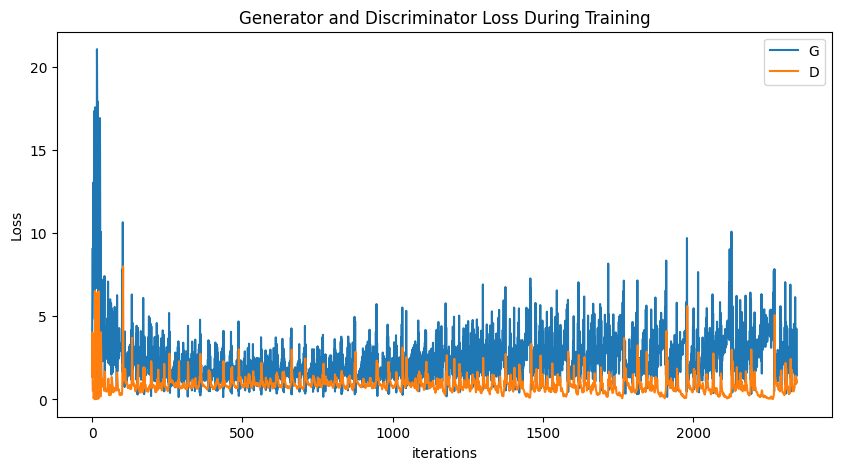

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

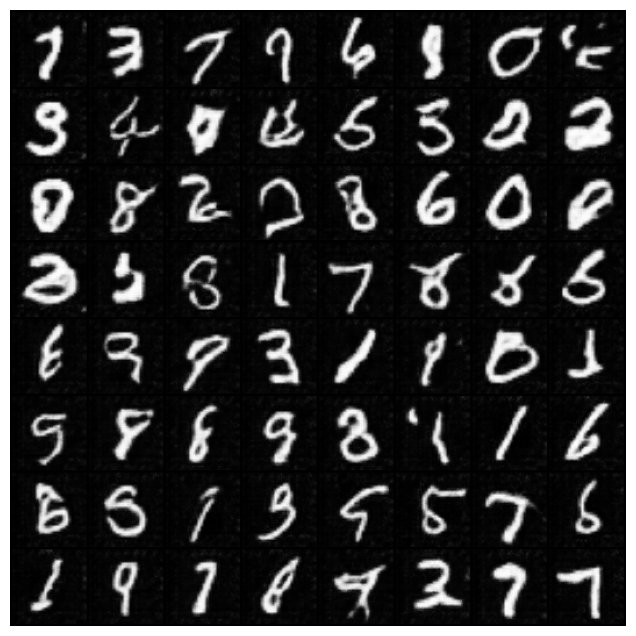

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

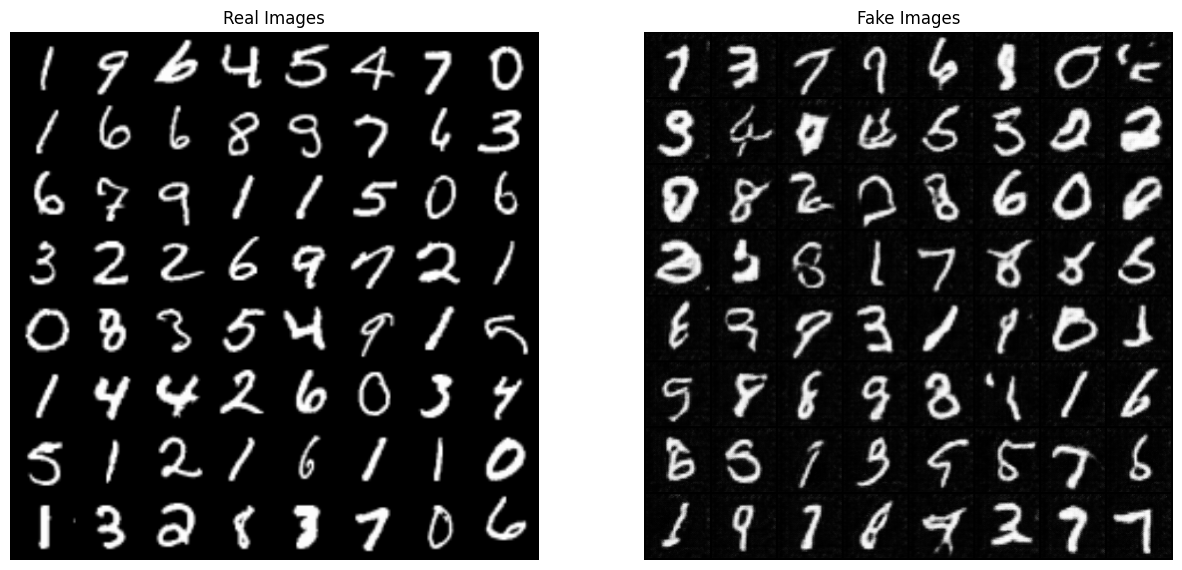

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()